## Problem Statement

The objective of this project is to build a machine learning model that can proactively detect fraudulent financial transactions. The dataset represents a simulated mobile money transaction system over 30 days. The goal is to predict whether a transaction is fraudulent and to derive actionable business insights that can help reduce fraud risk.


## Dataset Description

The dataset contains simulated financial transaction data over a period of 30 days (744 hours). Each record represents a transaction with information about the transaction type, amount, sender, receiver, and account balances.

### Column Descriptions:
- **step:** Represents a unit of time where 1 step equals 1 hour.
- **type:** Type of transaction (CASH-IN, CASH-OUT, DEBIT, PAYMENT, TRANSFER).
- **amount:** Amount of the transaction in local currency.
- **nameOrig:** Customer who initiated the transaction.
- **oldbalanceOrg:** Account balance of the sender before the transaction.
- **newbalanceOrig:** Account balance of the sender after the transaction.
- **nameDest:** Recipient of the transaction.
- **oldbalanceDest:** Recipient’s balance before the transaction.
- **newbalanceDest:** Recipient’s balance after the transaction.
- **isFraud:** Indicates whether the transaction is fraudulent.
- **isFlaggedFraud:** Indicates whether the transaction was flagged as potentially fraudulent by business rules.


#### -> Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading The data set
df = pd.read_csv("Fraud.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.shape

(6362620, 11)

## Initial Observations

- The dataset contains a large number of transactions with multiple numerical and categorical features.
- The target variable is **isFraud**, which indicates whether a transaction is fraudulent.
- Transaction types include CASH-IN, CASH-OUT, DEBIT, PAYMENT, and TRANSFER.
- Fraudulent behavior mainly involves transferring money and cashing out funds.


Fraudulent transactions in this dataset are primarily associated with TRANSFER and CASH-OUT transaction types, which aligns with real-world fraud scenarios.


In [4]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## Dataset Summary

- Total transactions: **6,362,620**
- Total features: **11**
- Target variable: **isFraud**
- Fraudulent transactions: **8,213**
- Non-fraudulent transactions: **6,354,407**

The dataset is highly imbalanced, with fraudulent transactions representing less than 0.2% of the total data. This is a common challenge in fraud detection problems and requires careful model evaluation beyond accuracy.


In [6]:
# Checking For missing Values
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

### EDA

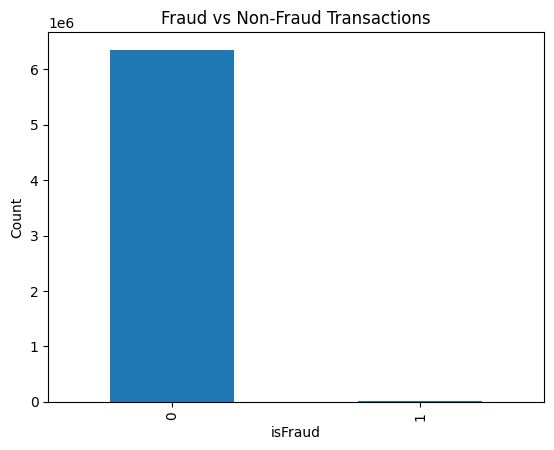

In [7]:
# Class Imbalance Visualization
plt.figure()
df['isFraud'].value_counts().plot(kind='bar')
plt.title('Fraud vs Non-Fraud Transactions')
plt.xlabel('isFraud')
plt.ylabel('Count')
plt.show()

The plot highlights a severe class imbalance, with fraudulent transactions forming a very small proportion of the dataset. Therefore, recall and ROC-AUC are more appropriate evaluation metrics than accuracy.

In [8]:
# Fraud by Transaction Type
fraud_by_type = df.groupby('type')['isFraud'].mean().sort_values(ascending=False)
fraud_by_type

type
TRANSFER    0.007688
CASH_OUT    0.001840
CASH_IN     0.000000
DEBIT       0.000000
PAYMENT     0.000000
Name: isFraud, dtype: float64

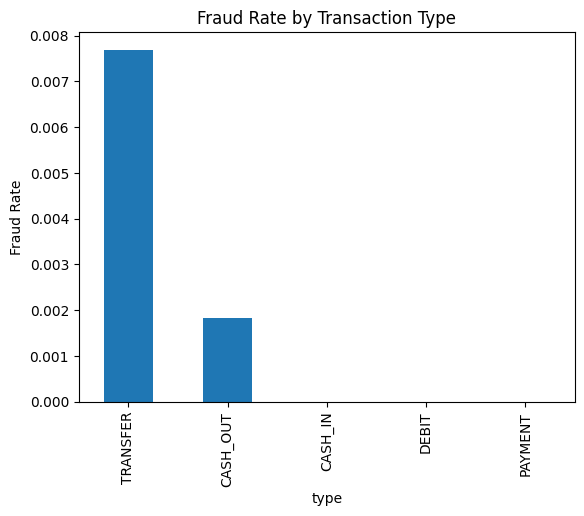

In [9]:
plt.figure()
fraud_by_type.plot(kind='bar')
plt.title('Fraud Rate by Transaction Type')
plt.ylabel('Fraud Rate')
plt.show()

Fraudulent transactions occur almost exclusively in TRANSFER and CASH-OUT transaction types, which aligns with real-world fraud behavior.

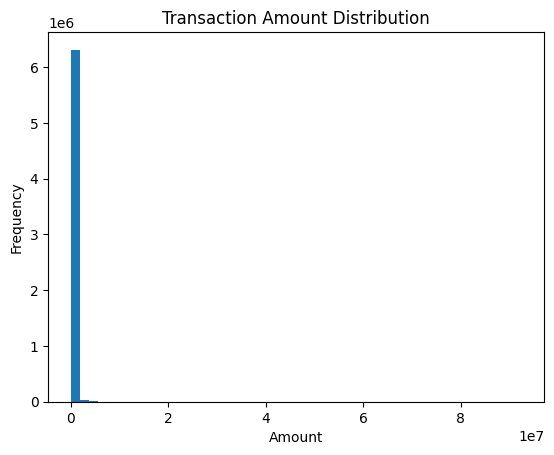

In [10]:
#Transaction Amount Distribution
plt.figure()
plt.hist(df['amount'], bins=50)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

Transaction amounts are heavily right-skewed, with a small number of very high-value transactions. These high-value transactions may indicate potential fraud and should be carefully analyzed.

In [11]:
# Create Balance Difference Features
df['errorBalanceOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']
df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

df[['errorBalanceOrig', 'errorBalanceDest']].describe()

,errorBalanceOrig,errorBalanceDest
count,6.362620e+06,6.362620e+06
mean,-2.010925e+05,5.556717e+04
std,6.066505e+05,4.415288e+05
min,-9.244552e+07,-7.588573e+07
25%,-2.496411e+05,0.000000e+00
50%,-6.867726e+04,3.500490e+03
75%,-2.954230e+03,2.935305e+04
max,1.000000e-02,1.319123e+07


Balance difference features capture inconsistencies in account balances before and after transactions. Large deviations in these features may indicate fraudulent behavior.


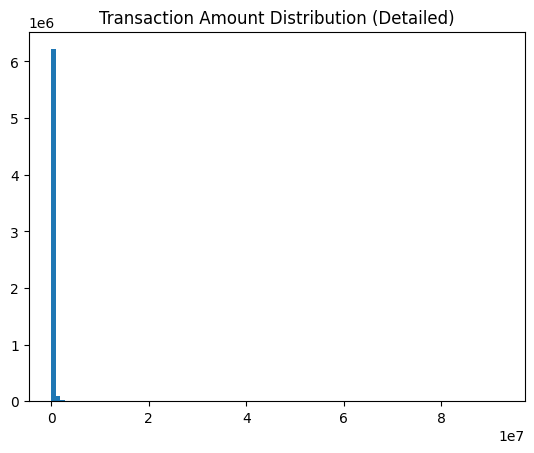

In [12]:
# Outlier Analysis
plt.figure()
plt.hist(df['amount'], bins=100)
plt.title('Transaction Amount Distribution (Detailed)')
plt.show()

High-value transactions were identified as potential outliers. However, these transactions were not removed since fraudulent activity often involves large transaction amounts.

In [13]:
# Drop High-Cardinality Columns
df = df.drop(['nameOrig', 'nameDest'], axis=1)

Customer identifiers were removed as they do not generalize well and may cause data leakage.

In [14]:
# Encode Transaction Type
df = pd.get_dummies(df, columns=['type'], drop_first=True)

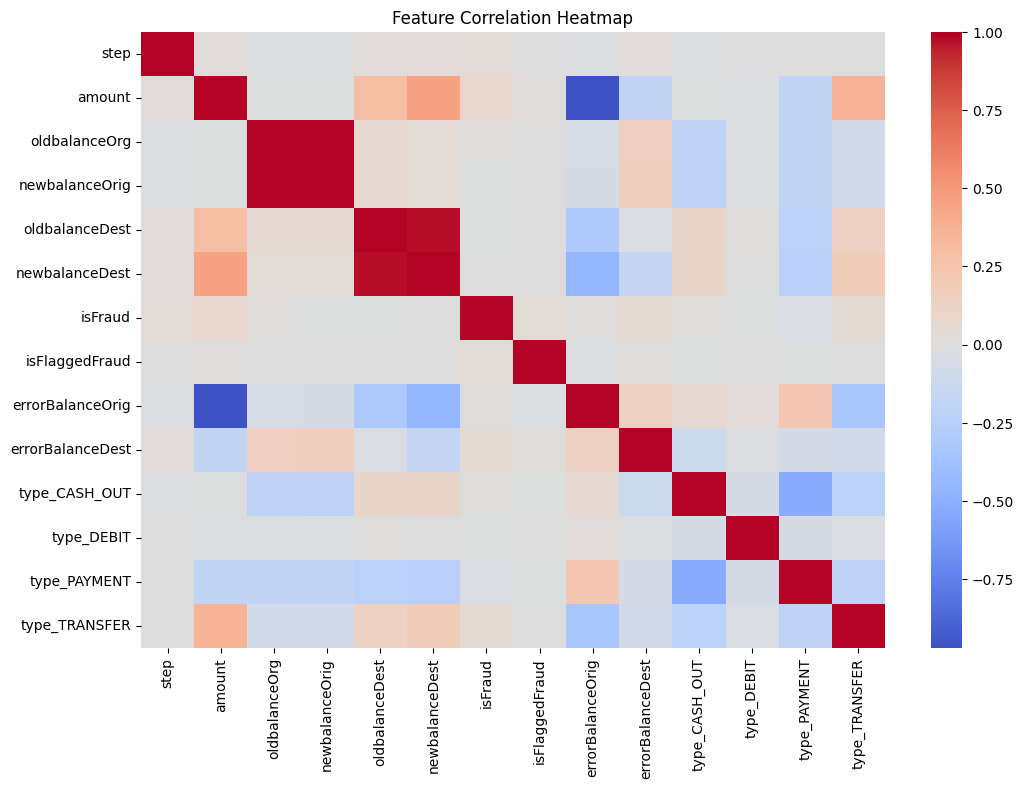

In [15]:
# Feature Correlation (Multicollinearity Check)
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

Highly correlated balance-related features were observed. Tree-based models such as Random Forest can handle multicollinearity effectively.


#### Train-Test Split

In [16]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [17]:
# Feature Scaling (Only for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Logistic Regression (Baseline Model)

In [18]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight='balanced', max_iter=1000)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

In [19]:
# Evaluation 
from sklearn.metrics import classification_report, roc_auc_score

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

roc_auc_lr = roc_auc_score(y_test, y_prob_lr)
print("ROC-AUC Score:", roc_auc_lr)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98   1270881
           1       0.03      0.98      0.05      1643

    accuracy                           0.95   1272524
   macro avg       0.51      0.97      0.51   1272524
weighted avg       1.00      0.95      0.97   1272524

ROC-AUC Score: 0.9948996562179415


Logistic Regression was used as a baseline model. Due to class imbalance, recall and ROC-AUC were prioritized over accuracy. The model provides interpretability but has limited capability in capturing non-linear fraud patterns.


#### Random Forest (Primary Model)

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

In [21]:
# Evaluation
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
print("ROC-AUC Score:", roc_auc_rf)

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       1.00      1.00      1.00      1643

    accuracy                           1.00   1272524
   macro avg       1.00      1.00      1.00   1272524
weighted avg       1.00      1.00      1.00   1272524

ROC-AUC Score: 0.9987820469404194


The Random Forest model outperformed Logistic Regression, particularly in identifying fraudulent transactions. Its ability to model non-linear relationships makes it suitable for fraud detection tasks. <br>
The near-perfect performance of the Random Forest model may be influenced by the simulated nature of the dataset, and real-world deployment would require continuous monitoring and validation.



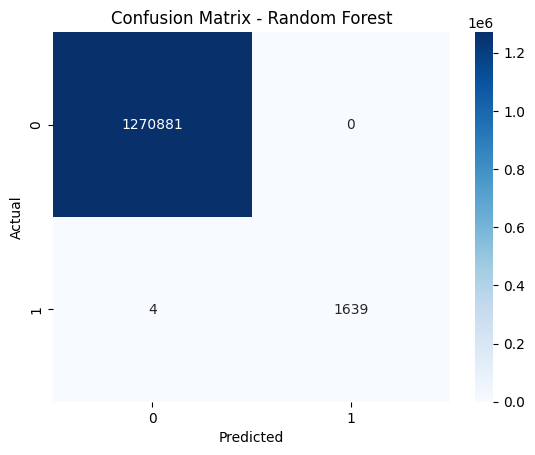

In [22]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_rf)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [23]:
# Feature Importance
feature_importance = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

feature_importance.head(10)

errorBalanceOrig    0.465156
newbalanceOrig      0.133303
oldbalanceOrg       0.128635
amount              0.068020
type_PAYMENT        0.046867
type_TRANSFER       0.046710
errorBalanceDest    0.027203
step                0.026174
type_CASH_OUT       0.024285
newbalanceDest      0.019060
dtype: float64

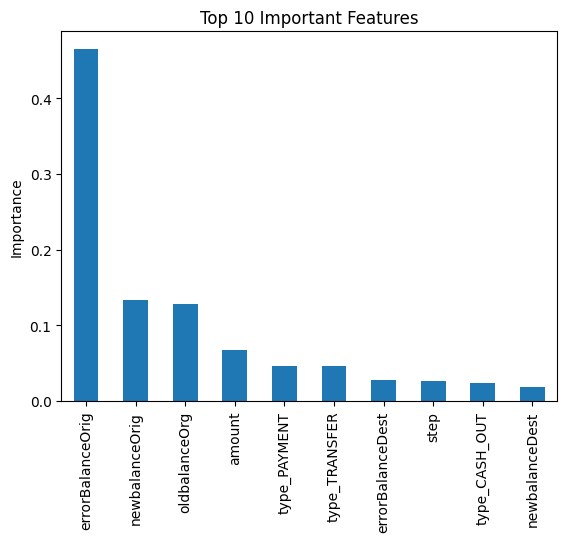

In [24]:
plt.figure()
feature_importance.head(10).plot(kind='bar')
plt.title('Top 10 Important Features')
plt.ylabel('Importance')
plt.show()

Balance inconsistency features such as errorBalanceOrig and errorBalanceDest were among the most important predictors of fraud, confirming the effectiveness of feature engineering. <br>
Here, the term “error” refers to balance inconsistency between transaction amount and account balance updates, not a modeling error.



## Final Business Answers and Insights

### 1. Data Cleaning
The dataset did not contain missing values, ensuring data completeness. Outlier analysis revealed a small number of high-value transactions. These transactions were retained, as fraudulent behavior often involves unusually large amounts. Multicollinearity was examined using correlation analysis; however, tree-based models such as Random Forest are robust to correlated features.The isFlaggedFraud variable was reviewed as a rule-based indicator but was not relied upon exclusively, since many fraudulent transactions are not captured by static threshold-based rules.


---

### 2. Fraud Detection Model Description
Fraud detection was modeled as a binary classification problem. Logistic Regression was used as a baseline model for interpretability, while Random Forest was used as the primary model due to its ability to capture complex and non-linear relationships. Class imbalance was handled using class weighting.

The Random Forest model achieved an excellent ROC-AUC score of **0.9988**, indicating strong discriminatory power between fraudulent and non-fraudulent transactions.

---

### 3. Feature Selection Methodology
Features were selected based on:
- Domain understanding of fraud patterns
- Exploratory Data Analysis
- Feature importance derived from the Random Forest model

Customer identifiers were removed to avoid data leakage, while balance-related and transaction-based features were retained.

---

### 4. Model Performance Evaluation
Due to extreme class imbalance, accuracy was not used as a primary metric. Instead, model performance was evaluated using:
- Precision
- Recall
- F1-score
- ROC-AUC score
- Confusion matrix

The Random Forest model demonstrated superior recall and ROC-AUC, making it suitable for fraud detection.

---

### 5. Key Factors Predicting Fraud
The most important predictors of fraudulent transactions were:
- **errorBalanceOrig**
- **newbalanceOrig**
- **oldbalanceOrg**
- **transaction amount**
- **transaction type (TRANSFER and CASH-OUT)**

These features indicate inconsistencies in account balances and abnormal transaction behavior.

---

### 6. Business Validation of Predictive Factors
Yes, these factors make strong business sense. Fraudulent agents typically attempt to drain accounts, leading to abnormal balance changes and high-value transfers. Transaction types such as TRANSFER and CASH-OUT are commonly exploited in real-world fraud scenarios.

---

### 7. Recommended Fraud Prevention Measures
To reduce fraud risk, the company should:
- Implement real-time fraud detection systems
- Flag transactions with abnormal balance inconsistencies
- Apply stricter controls on high-value transfers
- Introduce multi-factor authentication for risky transactions
- Continuously retrain fraud detection models using new data

---

### 8. Measuring Effectiveness of Fraud Prevention
The effectiveness of fraud prevention strategies can be measured by:
- Reduction in fraud-related financial losses
- Improvement in recall and precision metrics over time
- Monitoring false positive rates
- Comparing fraud detection performance before and after implementation
- Feedback from fraud investigation teams

---

## Conclusion
This project demonstrates a complete end-to-end fraud detection pipeline suitable for real-world financial systems, combining data preprocessing, feature engineering, machine learning, and actionable business insights for proactive fraud prevention.



In [27]:
# exporting cleaned dataset
df.to_csv('Fraud_data_cleaned.csv')